In [4]:
from pygsp.graphs import Graph
import numpy as np
from scipy.spatial import ConvexHull
from pyevtk.hl import unstructuredGridToVTK
from pyevtk.vtk import VtkTriangle, VtkQuad
from scipy.spatial import ConvexHull
bw = 4

class FullSphereEquiangular(Graph):
    """Modified from the class implemented by Droxef
    https://github.com/Droxef/PDMdeepsphere/
    """
    
    def __init__(self, bw=64, kernel_width=0.1):
       
        self.bw = bw

        ## sampling and coordinates calculation
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        self.coords = coords[2*bw-1:]
        

sphere = FullSphereEquiangular(bw=bw)
coords = sphere.coords

tri = ConvexHull(coords)
tri.simplices.shape

cells = {"triangle": tri.simplices}




In [5]:
conn = tri.simplices.flatten()
offset = np.arange(3,len(conn)+1, 3)
ctype = np.ones(len(offset))*VtkTriangle.tid


In [6]:
len(conn)

330

In [7]:
alpha = np.arange(2 * bw) * np.pi / bw
beta = np.arange(2 * bw) * np.pi / (2. * bw)
theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
ct = np.cos(theta).flatten()
st = np.sin(theta).flatten()
cp = np.cos(phi).flatten()
sp = np.sin(phi).flatten()
x = st * cp
y = st * sp
z = ct

In [16]:
class Equiangulartovtk:
     
    def make_coords(self, bw):
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        return coords[2*bw-1:]

    def __init__(self, bw=4):
        from pyevtk.hl import unstructuredGridToVTK
        from pyevtk.vtk import VtkTriangle, VtkQuad
        from scipy.spatial import ConvexHull
        
        self.coords = self.make_coords(bw)
        self.x = self.coords[:,0]
        self.y = self.coords[:,1]
        self.z = self.coords[:,2]
        width = 2*bw
        
        
        tri = []
        # north pole
        for i in range(width):
            tri.append([0, i+1, (i+1)%width+1])
        
        # inner layers
        for j in range(width-2):
            s = j*width  # s stands for "shift"
            for i in range(width):
                tri.append([s + (i+1), s + (i+1)%width+1, s + (i+1)%width+1 + width])
            for i in range(width):
                tri.append([s + (i+1), s + (i+1) + width, s + (i+1)%width + width + 1])
                
       
        npix = width*(width-1)+1
        last_row = np.arange(npix-width, npix)
        start = last_row[0]
        for i in last_row[:-2]:
            tri.append([start, i+1, i+2])
        
        
        
        self.conn = np.asarray(tri).flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid

    def __call__(self, title='unstructured', pointData=None):
        unstructuredGridToVTK(
            title,
            self.x,
            self.y,
            self.z,
            connectivity=self.conn,
            offsets=self.offset,
            cell_types=self.ctype,
            pointData={'Temp': x})

In [24]:
e = Equiangulartovtk(8)

In [25]:
e.conn

array([  0,   1,   2, ..., 225, 239, 240])

In [26]:
len(e.conn)

1434

In [27]:
e.offset

array([   3,    6,    9,   12,   15,   18,   21,   24,   27,   30,   33,
         36,   39,   42,   45,   48,   51,   54,   57,   60,   63,   66,
         69,   72,   75,   78,   81,   84,   87,   90,   93,   96,   99,
        102,  105,  108,  111,  114,  117,  120,  123,  126,  129,  132,
        135,  138,  141,  144,  147,  150,  153,  156,  159,  162,  165,
        168,  171,  174,  177,  180,  183,  186,  189,  192,  195,  198,
        201,  204,  207,  210,  213,  216,  219,  222,  225,  228,  231,
        234,  237,  240,  243,  246,  249,  252,  255,  258,  261,  264,
        267,  270,  273,  276,  279,  282,  285,  288,  291,  294,  297,
        300,  303,  306,  309,  312,  315,  318,  321,  324,  327,  330,
        333,  336,  339,  342,  345,  348,  351,  354,  357,  360,  363,
        366,  369,  372,  375,  378,  381,  384,  387,  390,  393,  396,
        399,  402,  405,  408,  411,  414,  417,  420,  423,  426,  429,
        432,  435,  438,  441,  444,  447,  450,  4

<IPython.core.display.Javascript object>


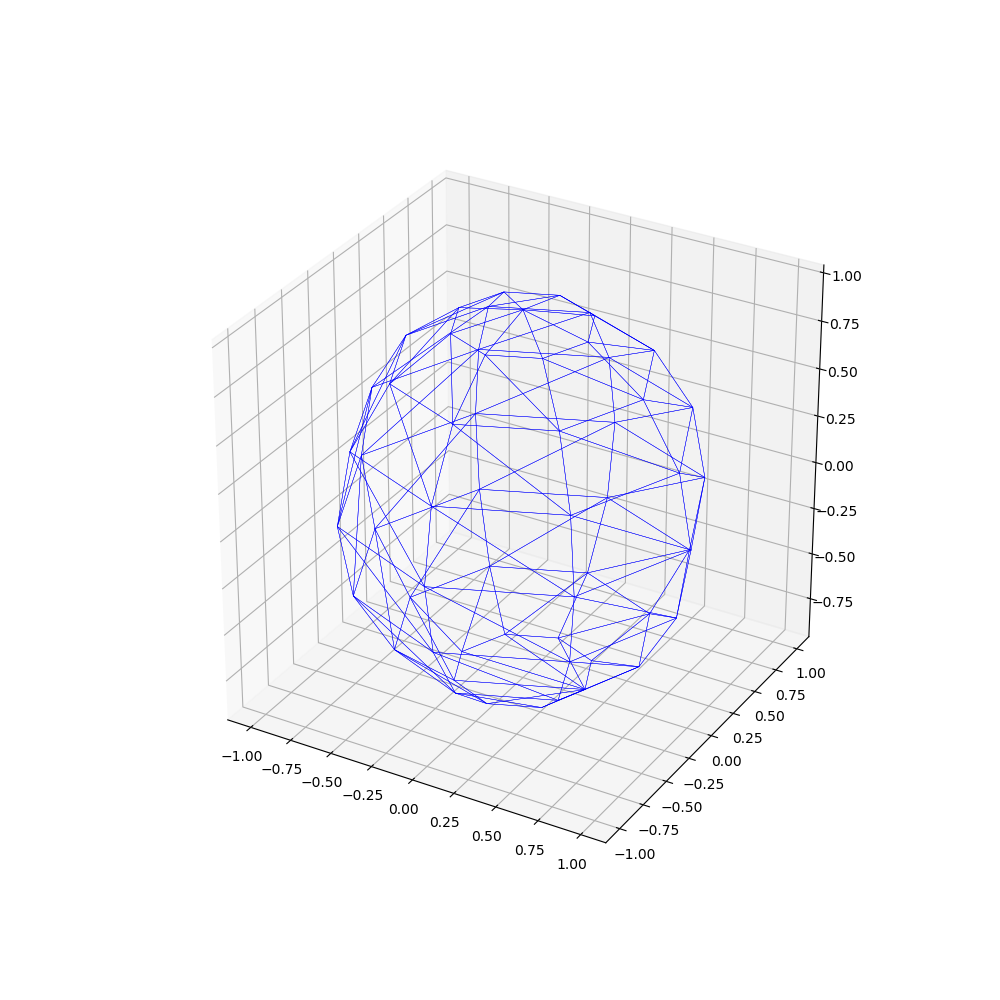

In [22]:
%matplotlib notebook 

simplices = e.conn.reshape((110, 3))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


for simplex in simplices:

    s = simplex.copy()
    s = np.append(s, simplex[0])
    ax.plot(coords[s][:,0], coords[s][:,1], coords[s][:,2], 'b-', LineWidth=0.3)

In [23]:
e()
